<a href="https://colab.research.google.com/github/hussnain-imtiaz/Machine-Deep-Learning-Projects/blob/master/vgg16_for_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting the tools ready:**

In [292]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime

#deep learning libraries
import tensorflow as tf
import tensorflow_hub as hub



In [293]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-29 18:30:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-29 18:30:01 (62.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [310]:
# Import series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, make_confusion_matrix

## **Getting the data ready:**

### Downloading and Extracting the data:

In [131]:
#!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

In [62]:
!wget http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip

--2021-07-29 15:44:16--  http://vision.ucsd.edu/extyaleb/CroppedYaleBZip/CroppedYale.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58493820 (56M) [application/zip]
Saving to: ‘CroppedYale.zip’

CroppedYale.zip     100%[===================>]  55.78M   582KB/s    in 97s     

2021-07-29 15:45:54 (587 KB/s) - ‘CroppedYale.zip’ saved [58493820/58493820]



In [ ]:
# uncomment if running again
#!rm -r /content/CroppedYale
!unzip CroppedYale.zip

In [ ]:
#!tar -xzvf lfw-funneled.tgz

### Data Loading and Preparation:

In [233]:
ROOT_FOLDER = '/content/CroppedYale'

### putting all the images in a list with the mapping of their relevant labels (person names)
dataset = []
for path in glob.iglob(os.path.join(ROOT_FOLDER, "**", "*.pgm")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
  
dataset = pd.DataFrame(dataset)

# filtering the data to get only the classes having at least 10 images 
dataset = dataset.groupby("person").filter(lambda x: len(x) > 10)
dataset.reset_index(drop=True, inplace=True)
dataset.head()

,person,path
0,yaleB01,/content/CroppedYale/yaleB01/yaleB01_P00A-060E...
1,yaleB01,/content/CroppedYale/yaleB01/yaleB01_P00A+130E...
2,yaleB01,/content/CroppedYale/yaleB01/yaleB01_P00A-005E...
3,yaleB01,/content/CroppedYale/yaleB01/yaleB01_P00_Ambie...
4,yaleB01,/content/CroppedYale/yaleB01/yaleB01_P00A+000E...


In [234]:
## lets see how many classes and images we have
dataset.nunique()

person      38
path      2452
dtype: int64

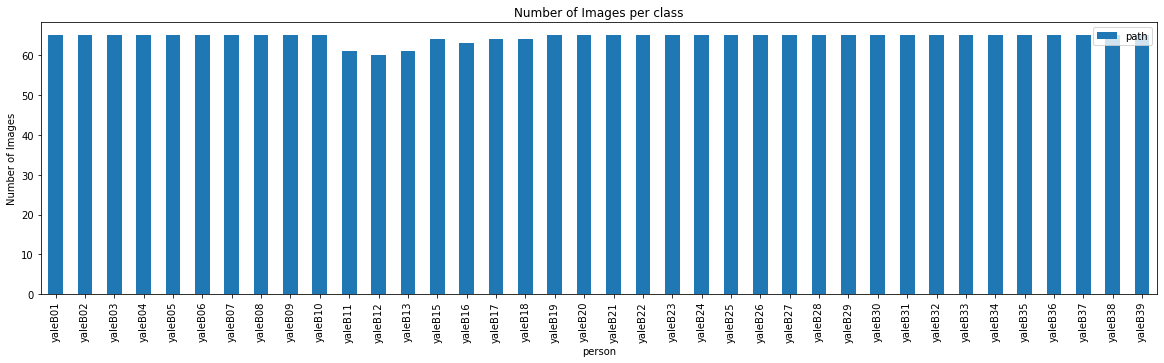

In [235]:
# visualizing the images count per class
dataset.groupby("person").count().plot(kind='bar', figsize=(20,5));
plt.ylabel('Number of Images');
plt.title('Number of Images per class');

#### Randomly ploting some data

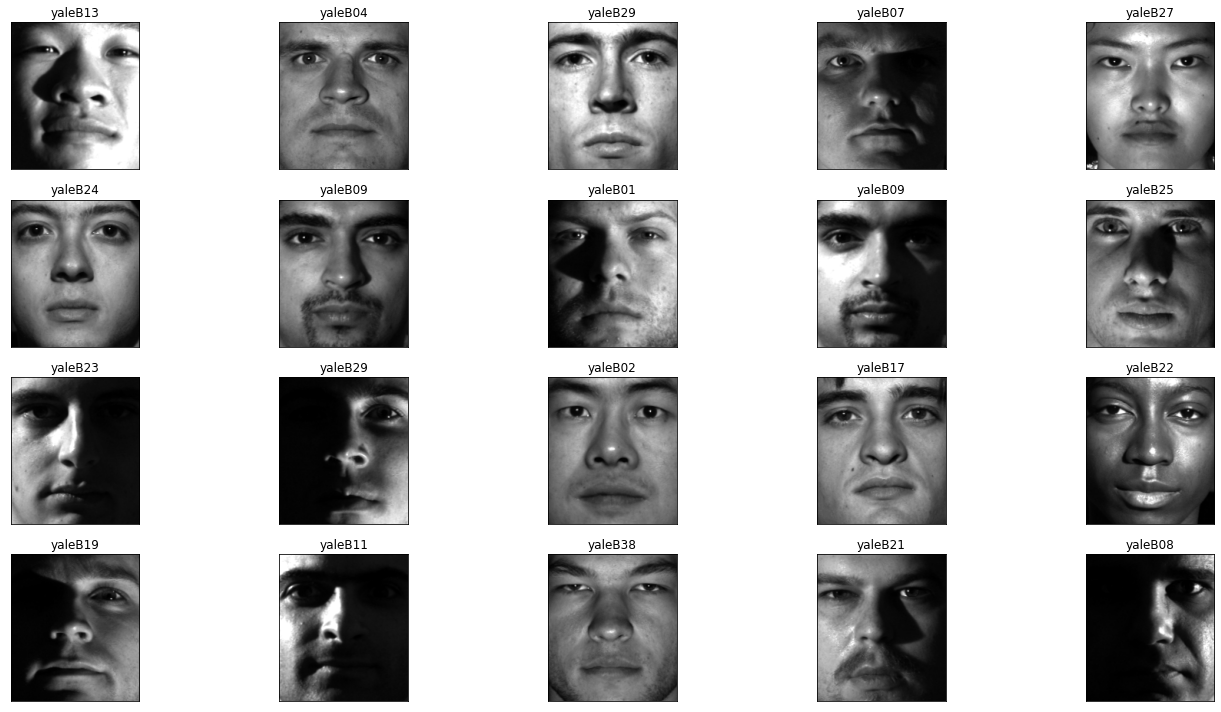

In [236]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = np.random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [237]:
X = dataset.path
y = dataset.person

### Spliting the data in Train and Test to be used by data Generator

In [238]:
from sklearn.model_selection import train_test_split
X_train, X_val, xt,yt      =train_test_split(X,
                                             y,
                                             test_size=0.2,
                                             random_state=8)

In [239]:
# to confirm that train and test data has same classes
xt.nunique() == yt.nunique()

True

#### Separating images in train and test folders

In [240]:
test_dir = "/content/CroppedYale/test/"
os.mkdir(test_dir)
for img_pth in X_val.tolist():
  dir = test_dir + img_pth.split('/')[3]+'/'
  if not os.path.exists(dir):
    os.mkdir(dir)
  shutil.move(img_pth,dir)

In [241]:
train_dir = "/content/CroppedYale/train/"
os.mkdir(train_dir)
for img_pth in X_train.tolist():
  dir = train_dir + img_pth.split('/')[3]+'/'
  if not os.path.exists(dir):
    os.mkdir(dir)
  shutil.move(img_pth,dir)

In [ ]:
# How many images in each folder?
# Walk through test data directory and list number of files
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
# How many images in each folder?
# Walk through train data directory and list number of files
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Data Preprocessing
Now we have got our data ready for preprocessing. Now its the time to make preprocessing pipeline.


#### Converting the images from pgm to jpg

In [ ]:
from PIL import Image
import os, glob
 
def batch_image(in_dir, out_dir):
    if not os.path.exists(out_dir):
        print(out_dir, 'is not existed.')
        os.mkdir(out_dir)
    
    if not os.path.exists(in_dir):
        print(in_dir, 'is not existed.')
        return -1
    count = 0
    for files in glob.iglob(os.path.join(in_dir, "*.pgm" )):
        filepath, filename = os.path.split(files)
        
        out_file = filename[:-4] + '.jpg'
        # print(filepath,',',filename, ',', out_file)
        im = Image.open(files)
        new_path = os.path.join(out_dir, out_file)
        print(count, ',', new_path)
        count = count + 1
        im.save(os.path.join(out_dir, out_file))

# converting training images
for path in os.listdir(train_dir):
  path = (os.path.join(train_dir, path))
  batch_image(path, path)
  
# converting testing images
for path in os.listdir(test_dir):
  path = (os.path.join(test_dir, path))
  batch_image(path, path)  

#### Reading the datda as expected by tensorflow.

In [276]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 1961 files belonging to 38 classes.
Found 491 files belonging to 38 classes.


## **Modelling**

#### Setting up the callbacks

In [277]:
# Create checkpoint callback to save model for later use
checkpoint_path = "1_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

### Creating and Compiling the model (Feature Extraction)

In [279]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [280]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling (Glob (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 38)                19494     
Total params: 14,734,182
Trainable params: 19,494
Non-trainable params: 14,714,688
_________________________________________________________________


In [283]:
%%time 
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_feature_extract= model.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
62/62 [==============================] - 13s 191ms/step - loss: 0.7913 - accuracy: 0.8302 - val_loss: 0.6241 - val_accuracy: 0.8750
Epoch 2/5
62/62 [==============================] - 12s 187ms/step - loss: 0.5573 - accuracy: 0.8955 - val_loss: 0.4688 - val_accuracy: 0.9062
Epoch 3/5
62/62 [==============================] - 12s 192ms/step - loss: 0.4517 - accuracy: 0.9184 - val_loss: 0.4254 - val_accuracy: 0.9062
Epoch 4/5
62/62 [==============================] - 10s 157ms/step - loss: 0.3590 - accuracy: 0.9454 - val_loss: 0.3918 - val_accuracy: 0.9062
Epoch 5/5
62/62 [==============================] - 10s 159ms/step - loss: 0.3039 - accuracy: 0.9551 - val_loss: 0.3244 - val_accuracy: 0.9375
CPU times: user 23.8 s, sys: 3.1 s, total: 26.9 s
Wall time: 1min 6s


#### Evaluation of Non fine tuned model

In [284]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

16/16 [==============================] - 3s 189ms/step - loss: 0.7048 - accuracy: 0.8310


[0.7047619819641113, 0.8309572339057922]

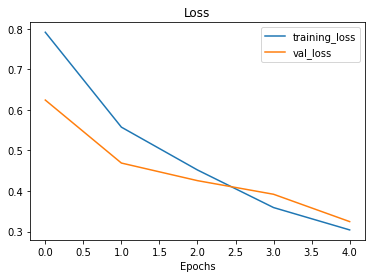

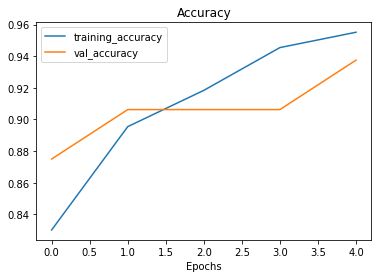

In [286]:
plot_loss_curves(history_feature_extract)

Ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

### Fine-tuning

In [287]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [288]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [289]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
vgg16 True
global_average_pooling True
output_layer True


In [290]:
# Fine-tune for more epochs
fine_tune_epochs = 10 # model has already done some epochs, this is the total number of epochs we're after 

history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                              initial_epoch=history_feature_extract.epoch[-1]) # start from previous last epoch

Epoch 5/10
62/62 [==============================] - 17s 221ms/step - loss: 0.7353 - accuracy: 0.8083 - val_loss: 0.4491 - val_accuracy: 0.8750
Epoch 6/10
62/62 [==============================] - 13s 209ms/step - loss: 0.1668 - accuracy: 0.9572 - val_loss: 0.1363 - val_accuracy: 0.9531
Epoch 7/10
62/62 [==============================] - 13s 209ms/step - loss: 0.0996 - accuracy: 0.9791 - val_loss: 0.2615 - val_accuracy: 0.9062
Epoch 8/10
62/62 [==============================] - 11s 181ms/step - loss: 0.1012 - accuracy: 0.9755 - val_loss: 0.3037 - val_accuracy: 0.8594
Epoch 9/10
62/62 [==============================] - 14s 216ms/step - loss: 0.0796 - accuracy: 0.9816 - val_loss: 0.1797 - val_accuracy: 0.9219
Epoch 10/10
62/62 [==============================] - 12s 188ms/step - loss: 0.0739 - accuracy: 0.9847 - val_loss: 0.0931 - val_accuracy: 0.9688


In [295]:
# Evaluate fine-tuned model on the whole test dataset
results_fine_tune = model.evaluate(test_data)
results_fine_tune

16/16 [==============================] - 3s 180ms/step - loss: 0.3425 - accuracy: 0.9124


[0.3424763083457947, 0.9124236106872559]

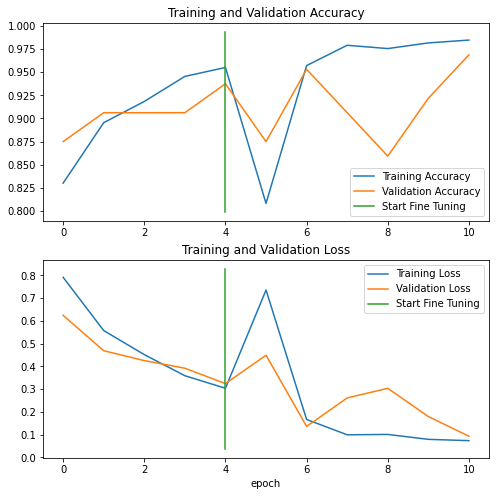

In [296]:
# compare both of the histories objects
compare_historys(original_history=history_feature_extract,
                 new_history=history_fine_tune,
                 initial_epochs=5)

#### Saving our trained model

In [297]:
# # Save model to drive so it can be used later 
# model.save("path")

## **Detailed Evaluation**

#### Predictions on test data using the model

In [298]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

16/16 [==============================] - 2s 139ms/step


In [299]:
# total predictions: should be equal to num of images in test set
len(pred_probs)

491

In [301]:
pred_probs.shape # containing an array for each image

(491, 38)

In [302]:
# lets see how they look like
pred_probs[:2]

array([[9.9860603e-01, 2.2088123e-15, 6.0511651e-10, 1.4542965e-06,
        9.2063951e-17, 4.7025488e-11, 4.7364695e-10, 1.0431104e-15,
        2.0691333e-12, 1.5127150e-10, 8.5918399e-12, 1.9200363e-13,
        1.0472680e-13, 3.7067951e-13, 2.4586392e-11, 2.3234914e-10,
        2.3588715e-09, 5.6159230e-08, 1.3765683e-03, 4.1256865e-10,
        5.0931840e-17, 3.9784953e-09, 9.7579619e-14, 1.6560060e-12,
        4.6717041e-08, 8.9773242e-18, 8.8019503e-16, 3.7718845e-08,
        1.5718135e-05, 2.9492290e-16, 5.9524467e-13, 3.0471090e-13,
        3.3269705e-22, 6.4788000e-15, 4.8112755e-15, 1.9598830e-12,
        5.2657388e-12, 7.4111384e-08],
       [9.9996758e-01, 5.7325889e-13, 1.5485316e-08, 4.5608968e-07,
        3.9463692e-17, 1.9017468e-11, 1.0184362e-08, 4.1603317e-14,
        2.2554528e-11, 3.4524838e-11, 2.7675819e-13, 4.8234675e-13,
        9.0533830e-11, 3.1695388e-10, 5.6815941e-12, 7.8295714e-10,
        2.7126329e-10, 1.0626883e-05, 7.9665715e-06, 5.7608662e-10,
        1

In [303]:
#Now Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
pred_classes

#### Unbatchyfy the test data to get actual labels

In [306]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)


In [307]:
y_labels[:10] # how they look like now

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [308]:
len(y_labels) # same as preds

491

#### Accuracy score

In [316]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_labels, pred_classes)
precision = precision_score(y_labels, pred_classes,average='weighted')
recall = recall_score(y_labels, pred_classes,average='weighted')
f1 = f1_score(y_labels, pred_classes, average='weighted')
print('accuracy:', accuracy, 'precision:', precision, 'recall:', recall, 'f1-score:', f1)

accuracy: 0.9124236252545825 precision: 0.9258149945777236 recall: 0.9124236252545825 f1-score: 0.9128382152917525


#### Confusion Matrix

In [317]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['yaleB01',
 'yaleB02',
 'yaleB03',
 'yaleB04',
 'yaleB05',
 'yaleB06',
 'yaleB07',
 'yaleB08',
 'yaleB09',
 'yaleB10']

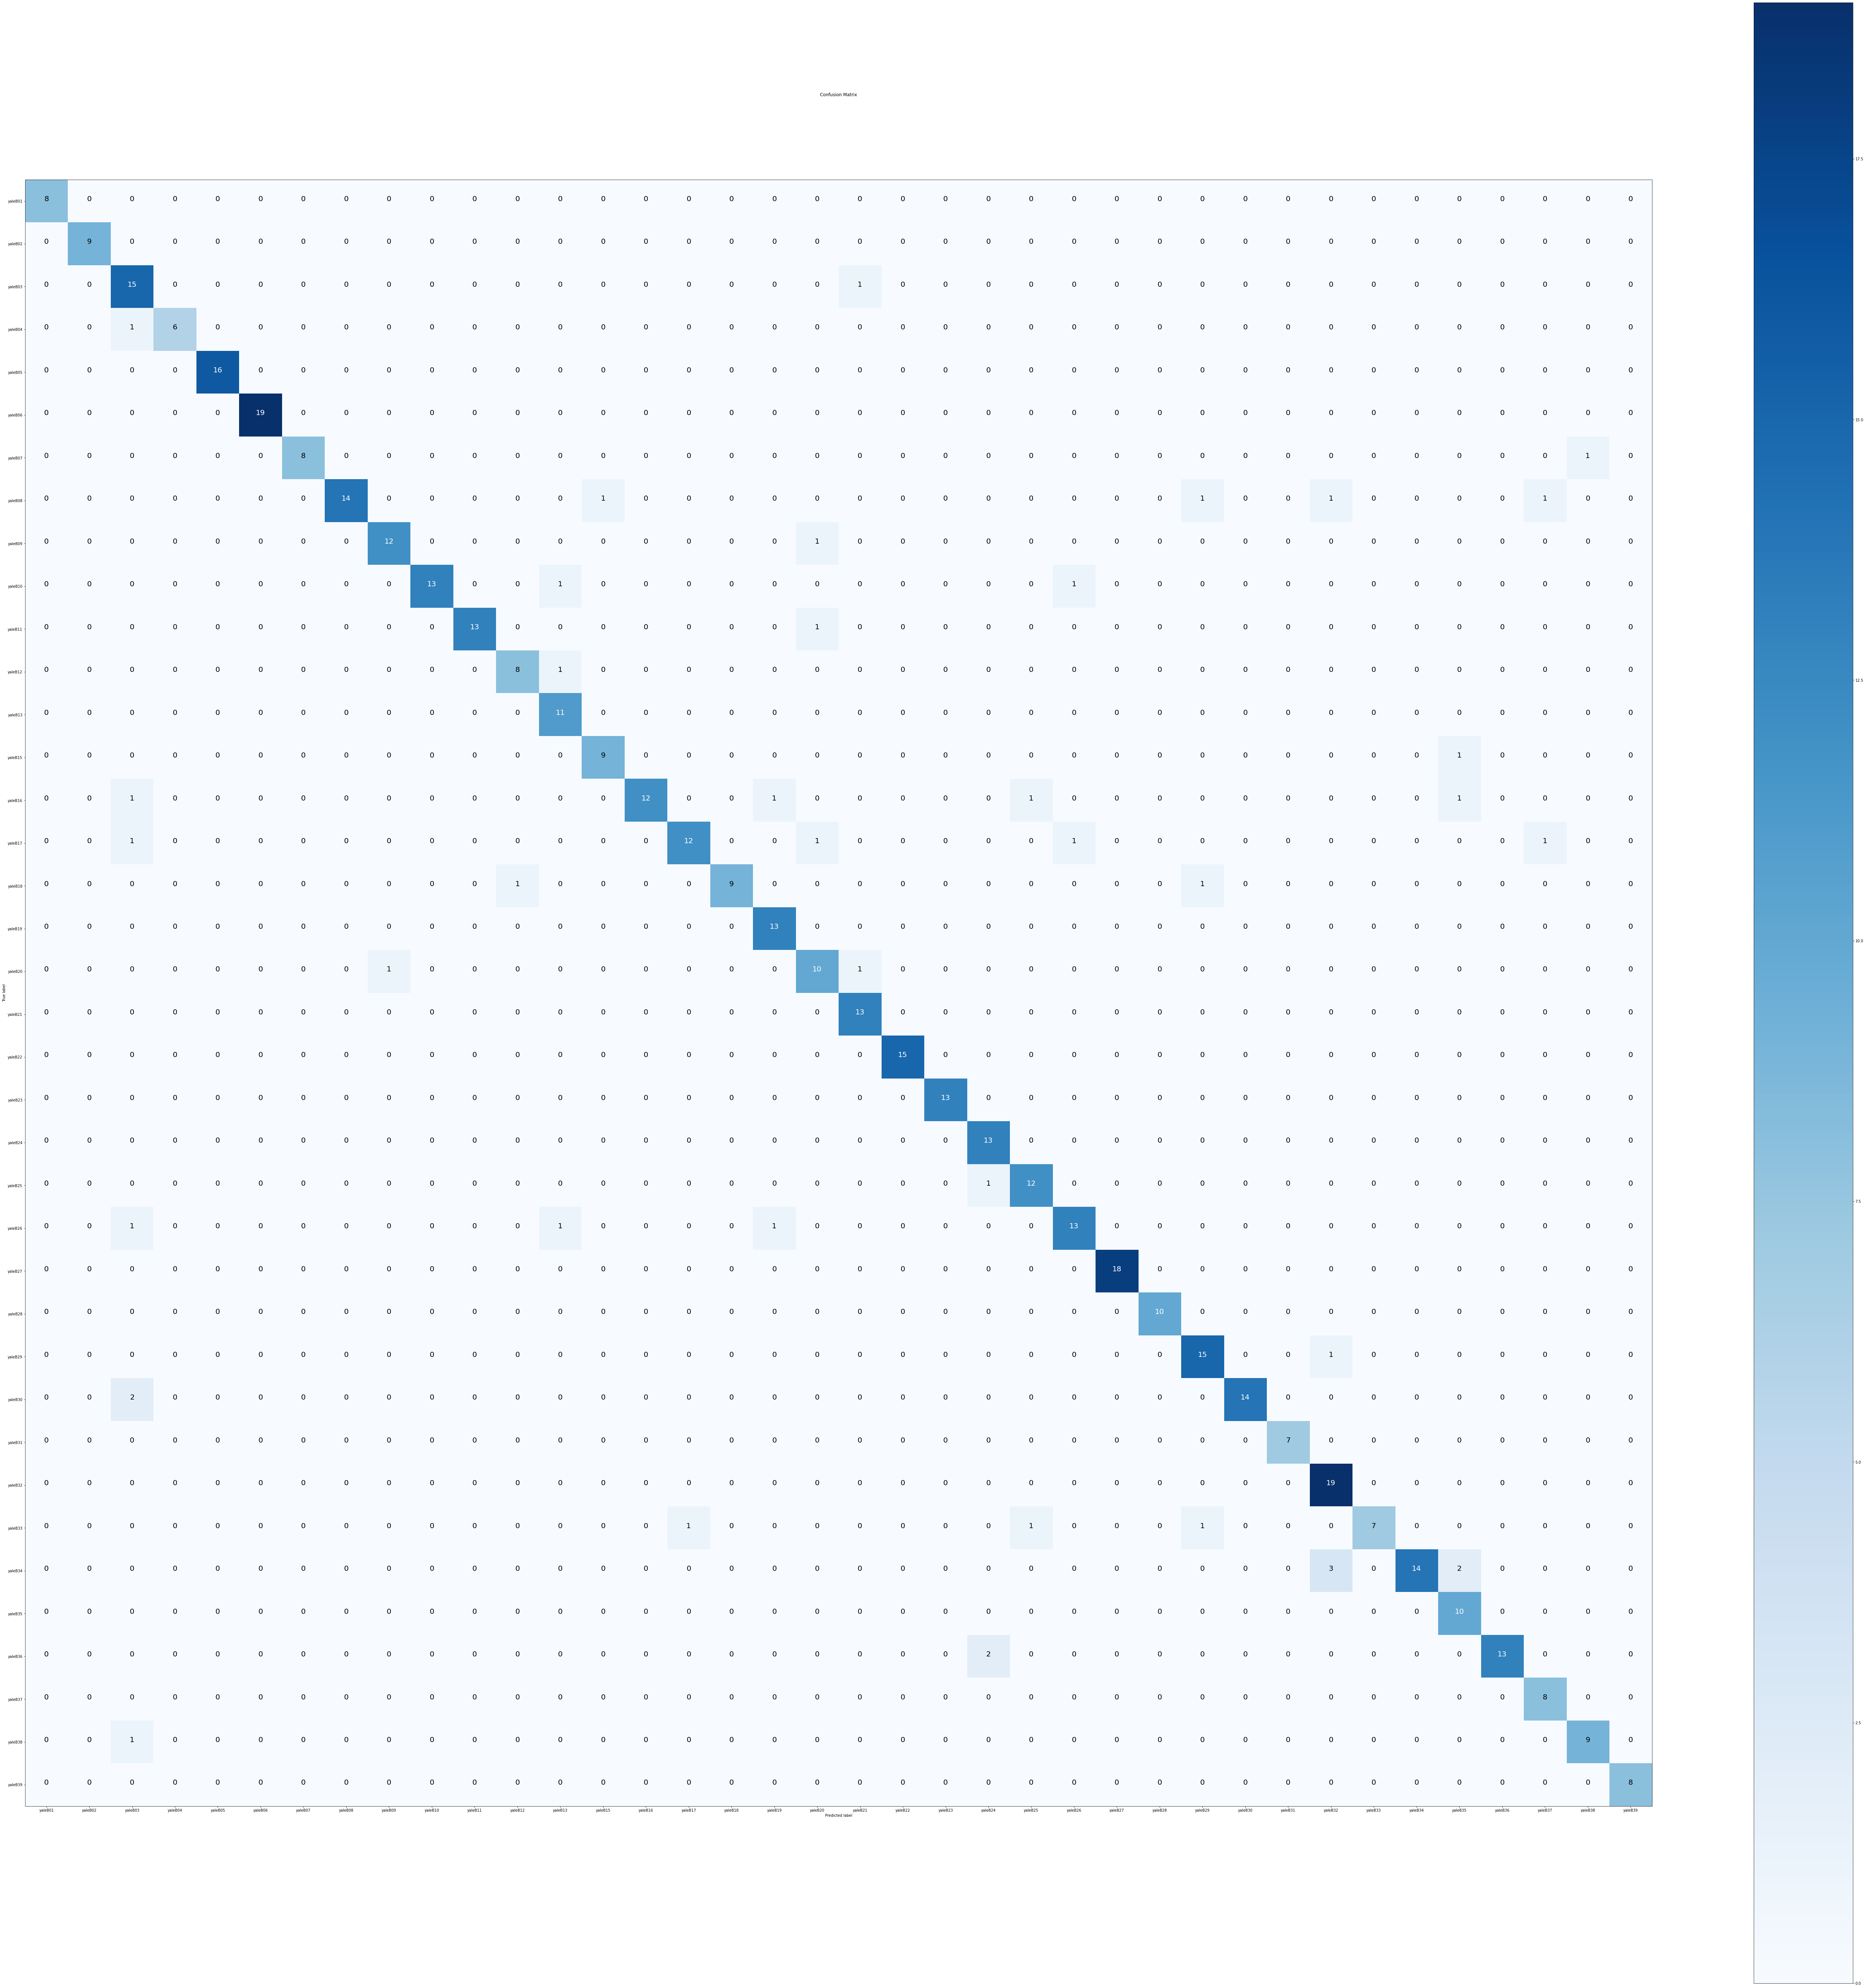

In [318]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

#### Classification Report

In [321]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         9
           2       0.68      0.94      0.79        16
           3       1.00      0.86      0.92         7
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        19
           6       1.00      0.89      0.94         9
           7       1.00      0.78      0.88        18
           8       0.92      0.92      0.92        13
           9       1.00      0.87      0.93        15
          10       1.00      0.93      0.96        14
          11       0.89      0.89      0.89         9
          12       0.79      1.00      0.88        11
          13       0.90      0.90      0.90        10
          14       1.00      0.75      0.86        16
          15       0.92      0.75      0.83        16
          16       1.00      0.82      0.90        11
          17       0.87    

#### Visualizing false predictions occured very often

In [323]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("/content/CroppedYale/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/CroppedYale/test/yaleB01/yaleB01_P00A+005E+10.jpg',
 b'/content/CroppedYale/test/yaleB01/yaleB01_P00A+005E-10.jpg',
 b'/content/CroppedYale/test/yaleB01/yaleB01_P00A+025E+00.jpg',
 b'/content/CroppedYale/test/yaleB01/yaleB01_P00A+060E+20.jpg',
 b'/content/CroppedYale/test/yaleB01/yaleB01_P00A+070E+00.jpg',
 b'/content/CroppedYale/test/yaleB01/yaleB01_P00A+110E+65.jpg',
 b'/content/CroppedYale/test/yaleB01/yaleB01_P00A-070E+45.jpg',
 b'/content/CroppedYale/test/yaleB01/yaleB01_P00A-110E+65.jpg',
 b'/content/CroppedYale/test/yaleB02/yaleB02_P00A+015E+20.jpg',
 b'/content/CroppedYale/test/yaleB02/yaleB02_P00A+050E-40.jpg']

In [324]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.998606,yaleB01,yaleB01
1,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.999968,yaleB01,yaleB01
2,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.999226,yaleB01,yaleB01
3,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.983586,yaleB01,yaleB01
4,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.998020,yaleB01,yaleB01


In [325]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.998606,yaleB01,yaleB01,True
1,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.999968,yaleB01,yaleB01,True
2,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.999226,yaleB01,yaleB01,True
3,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.983586,yaleB01,yaleB01,True
4,b'/content/CroppedYale/test/yaleB01/yaleB01_P0...,0,0,0.998020,yaleB01,yaleB01,True


In [328]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(10)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
241,b'/content/CroppedYale/test/yaleB20/yaleB20_P0...,18,19,0.991924,yaleB20,yaleB21,False
128,b'/content/CroppedYale/test/yaleB10/yaleB10_P0...,9,12,0.958789,yaleB10,yaleB13,False
124,b'/content/CroppedYale/test/yaleB10/yaleB10_P0...,9,24,0.908201,yaleB10,yaleB26,False
182,b'/content/CroppedYale/test/yaleB16/yaleB16_P0...,14,23,0.898623,yaleB16,yaleB25,False
130,b'/content/CroppedYale/test/yaleB11/yaleB11_P0...,10,18,0.827062,yaleB11,yaleB20,False
152,b'/content/CroppedYale/test/yaleB12/yaleB12_P0...,11,12,0.781274,yaleB12,yaleB13,False
186,b'/content/CroppedYale/test/yaleB16/yaleB16_P0...,14,17,0.629906,yaleB16,yaleB19,False
39,b'/content/CroppedYale/test/yaleB04/yaleB04_P0...,3,2,0.598077,yaleB04,yaleB03,False
373,b'/content/CroppedYale/test/yaleB30/yaleB30_P0...,28,2,0.595444,yaleB30,yaleB03,False
212,b'/content/CroppedYale/test/yaleB18/yaleB18_P0...,16,11,0.586225,yaleB18,yaleB12,False


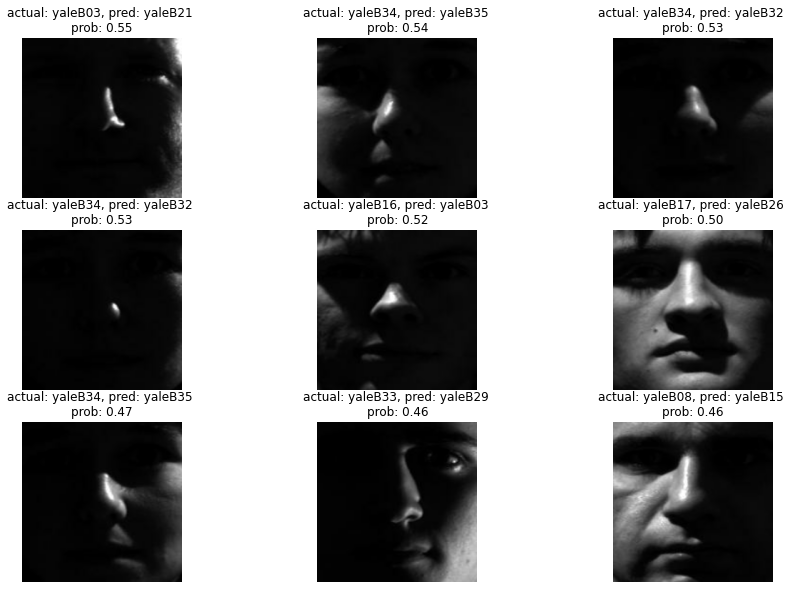

In [330]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

## **Predictions on unseen Images**

In [334]:
#preprocess test image
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, 3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [342]:
# loading the image, mapping the labels and visualizing the results
filepath = '/content/CroppedYale/test/yaleB03/yaleB03_P00A+005E-10.jpg'
class_name = filepath.split('/')[4]
img = load_and_prep_image(filepath, scale=False) 
pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
pred_class = class_names[pred_prob.argmax()] # find the predicted class 

In [343]:
pred_class

'yaleB03'

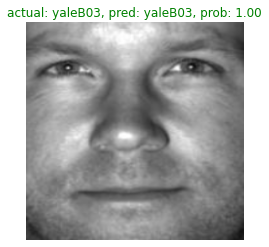

In [344]:
## visualizing
plt.imshow(img/255.)
if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
else:
    title_color = "r"
plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
plt.axis(False);